# XGboost - Invoice Risk

This notebook features XGboost against a CSV input file to build a Binary Classifer. It is inspired by this [notebok](https://github.com/abaranovskis-redsamurai/automation-repo/blob/master/invoice-risk-model-local.ipynb)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import pickle
from matplotlib import pyplot

In [2]:

df = pd.read_csv('../data/invoice_data_prog_processed.csv')
df.head()

,invoice_risk_decision,customer,payment_due_date,payment_date,grand_total
0,0,id_24,2,2,64.25
1,0,id_11,3,3,50.34
2,0,id_29,4,4,40.03
3,0,id_28,4,2,94.86
4,1,id_13,2,8,65.15


In [3]:
print('Number of rows in dataset: {df.shape[0]}')
print(df[df.columns[0]].value_counts())

Number of rows in dataset: {df.shape[0]}
0    171
1    135
Name: invoice_risk_decision, dtype: int64


In [4]:
# One hot encode customer IDs
encoded_data = pd.get_dummies(df)
encoded_data.head()

,invoice_risk_decision,payment_due_date,payment_date,grand_total,customer_id_11,customer_id_12,customer_id_13,customer_id_14,customer_id_15,customer_id_18,...,customer_id_45,customer_id_46,customer_id_47,customer_id_48,customer_id_49,customer_id_50,customer_id_6,customer_id_7,customer_id_8,customer_id_9
0,0,2,2,64.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3,3,50.34,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,4,4,40.03,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4,2,94.86,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,8,65.15,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Look at the degree of correlation of our features against the invoice_risk_decision
corrs = encoded_data.corr()['invoice_risk_decision'].abs()
columns = corrs[corrs > .1].index
corrs = corrs.filter(columns)
corrs

invoice_risk_decision    1.000000
payment_due_date         0.349879
payment_date             0.432499
grand_total              0.182643
customer_id_11           0.166688
customer_id_12           0.111988
customer_id_19           0.110278
customer_id_27           0.102258
customer_id_4            0.130518
customer_id_44           0.114517
customer_id_50           0.179509
customer_id_8            0.131556
Name: invoice_risk_decision, dtype: float64

In [7]:
# split data into X and y
X = encoded_data.iloc[:, 1:44]
Y = encoded_data.iloc[:, 0:1]

In [8]:
# Retain 10% of the dataset for Test
headers = list(X)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=0)

print(train_X.shape, test_X.shape)
print()
print('Number of rows in Train dataset: {train_df.shape[0]}')
print(train_Y['invoice_risk_decision'].value_counts())
print()
print('Number of rows in Test dataset: {test_df.shape[0]}')
print(test_Y['invoice_risk_decision'].value_counts())


(275, 43) (31, 43)

Number of rows in Train dataset: {train_df.shape[0]}
0    154
1    121
Name: invoice_risk_decision, dtype: int64

Number of rows in Test dataset: {test_df.shape[0]}
0    17
1    14
Name: invoice_risk_decision, dtype: int64


In [10]:
%%time

# Fit XGboost as a binary classifier on the training data and evaluate against the test set
# Add early stopping
model = xgb.XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1)
eval_set = [(train_X, train_Y), (test_X, test_Y)]
model.fit(train_X, train_Y.values.ravel(), early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.087273	validation_0-logloss:0.631858	validation_1-error:0.193548	validation_1-logloss:0.643774
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.087273	validation_0-logloss:0.581629	validation_1-error:0.193548	validation_1-logloss:0.607257
[2]	validation_0-error:0.090909	validation_0-logloss:0.537914	validation_1-error:0.225806	validation_1-logloss:0.575808
[3]	validation_0-error:0.090909	validation_0-logloss:0.500498	validation_1-error:0.225806	validation_1-logloss:0.55041
[4]	validation_0-error:0.090909	validation_0-logloss:0.466848	validation_1-error:0.225806	validation_1-logloss:0.522722
[5]	validation_0-error:0.090909	validation_0-logloss:0.43845	validation_1-error:0.225806	validation_1-logloss:0.507767
[6]	validation_0-error:0.090909	validation_0-logloss:0.412471	validation_1-error:0.225806	validation_1-logloss:0.4871

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[77]	validation_0-error:0.014545	validation_0-logloss:0.092918	validation_1-error:0.096774	validation_1-logloss:0.219752
[78]	validation_0-error:0.014545	validation_0-logloss:0.091881	validation_1-error:0.096774	validation_1-logloss:0.221083
[79]	validation_0-error:0.014545	validation_0-logloss:0.091233	validation_1-error:0.096774	validation_1-logloss:0.221287
[80]	validation_0-error:0.014545	validation_0-logloss:0.0905	validation_1-error:0.096774	validation_1-logloss:0.221896
[81]	validation_0-error:0.014545	validation_0-logloss:0.08982	validation_1-error:0.096774	validation_1-logloss:0.223011
[82]	validation_0-error:0.014545	validation_0-logloss:0.089127	validation_1-error:0.096774	validation_1-logloss:0.224999
[83]	validation_0-error:0.010909	validation_0-logloss:0.088424	validation_1-error:0.096774	validation_1-logloss:0.22531
[84]	validation_0-error:0.010909	validation_0-logloss:0.087861	validation_1-error:0.096774	validation_1-logloss:0.223409
Stopping. Best iteration:
[74]	valid

XGBClassifier(max_depth=4, n_estimators=200, subsample=0.9)

In [11]:
# make predictions for test data
y_pred = model.predict(test_X)
predictions = [round(value) for value in y_pred]

In [12]:
# evaluate predictions
accuracy = accuracy_score(test_Y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.32%


In [13]:
# Make DataFrame for model
input_variables = pd.DataFrame([[3,4,50.75,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
                                columns=headers, 
                                dtype=float,
                                index=['input'])

# Get the model's prediction
prediction = model.predict(input_variables)
print("Prediction: ", prediction)
prediction_proba = model.predict_proba(input_variables)
print("Probabilities: ", prediction_proba)

Prediction:  [0]
Probabilities:  [[0.9017306  0.09826939]]


In [14]:
# save model to file
pickle.dump(model, open("invoice-risk-model.pkl", "wb"))

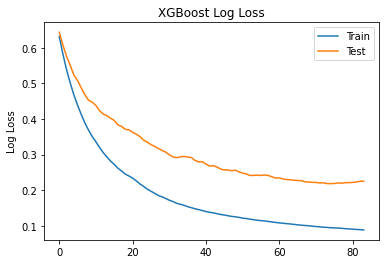

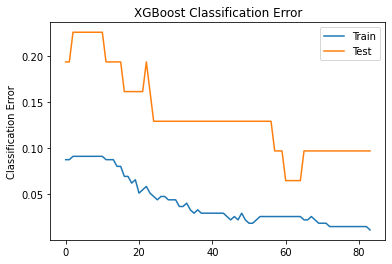

In [15]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()